In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import glob, os

label_to_idx = {
    "andhra":0,
    "gujrat":1,
    "jharkhand":2,
    "karnataka":3,
    "kerala":4,
    "tamil":5
}


In [ ]:
class SeqDataset(Dataset):
    def __init__(self, root, max_len=300):
        self.data = []
        self.labels = []
        self.max_len = max_len

        files = glob.glob(os.path.join(root, "*.pt"))
        print("Found:", len(files), "files")

        for f in files:
            name = os.path.basename(f).lower()

            lbl = next((label_to_idx[s] for s in label_to_idx if s in name), None)
            if lbl is None:
                continue

            x = torch.load(f)  # load once

            # pre-pad
            if x.shape[0] > max_len:
                x = x[:max_len]
            else:
                pad = max_len - x.shape[0]
                x = torch.cat([x, torch.zeros(pad, x.shape[1])], 0)

            self.data.append(x)
            self.labels.append(lbl)

        print("Loaded into RAM:", len(self.data))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], torch.tensor(self.labels[idx])


In [ ]:
#CNN
class CNN1D(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(768, 256, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(256, 128, 5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)   # (B, 768, T)
        x = self.conv(x)
        x = x.squeeze(-1)
        return self.fc(x)


In [ ]:
#BiLSTM

class BiLSTM(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(768, 256, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)


In [ ]:
#Transformer model
class TransformerModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=768,
            nhead=8,
            batch_first=True,
            dim_feedforward=1024
        )
        self.tf = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        out = self.tf(x)
        out = out.mean(dim=1)   # average pooling
        return self.fc(out)


In [ ]:
cnn = CNN1D(6)
lstm = BiLSTM(6)
tfm = TransformerModel(6)

cnn.load_state_dict(torch.load("/content/drive/MyDrive/models/cnn_seq.pt"))
lstm.load_state_dict(torch.load("/content/drive/MyDrive/models/lstm_seq.pt"))
tfm.load_state_dict(torch.load("/content/drive/MyDrive/models/transformer_seq.pt"))


<All keys matched successfully>

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def train(model, loader, epochs=5):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    for e in range(epochs):
        model.train()
        correct = 0
        total = 0

        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()

            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        print(f"Epoch {e+1}: Acc = {correct/total:.4f}")


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np

def evaluate_model(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            p = out.argmax(1).cpu().numpy()
            preds.extend(p)
            trues.extend(y.numpy())

    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='weighted')
    return acc, f1, confusion_matrix(trues, preds), classification_report(trues, preds)


In [ ]:
!mkdir -p /content/hubert_local
!cp -r "/content/drive/MyDrive/hubert_sequence"/* /content/hubert_local/


In [ ]:
dataset = SeqDataset("/content/hubert_local")
loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

len(dataset)


NameError: name 'SeqDataset' is not defined

# **cnn hyperparameter tuning and batch normalization**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#cnn variant a: 7 kernels instead of 5
class CNN_Tuned_A(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(768, 256, 7, padding=3),
            nn.ReLU(),
            nn.Conv1d(256, 128, 7, padding=3),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv(x).squeeze(-1)
        return self.fc(x)


In [ ]:
#cnn variant b: add dropout
class CNN_Tuned_B(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(768, 256, 5, padding=2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv1d(256, 128, 5, padding=2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv(x).squeeze(-1)
        return self.fc(x)


In [ ]:
#CNN baseline + batch normalization
class CNN1D_BN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(768, 256, 5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Conv1d(256, 128, 5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)   # (B, 768, T)
        x = self.conv(x)        # (B, 128, 1)
        x = x.squeeze(-1)       # (B, 128)
        return self.fc(x)


In [ ]:
cnn_A = CNN_Tuned_A(6)
train(cnn_A, loader, epochs=5)


Epoch 1: Acc = 0.6852
Epoch 2: Acc = 0.9500
Epoch 3: Acc = 0.9813
Epoch 4: Acc = 0.9898
Epoch 5: Acc = 0.9929


In [ ]:
cnn_B = CNN_Tuned_B(6)
train(cnn_B, loader, epochs=5)


Epoch 1: Acc = 0.6142
Epoch 2: Acc = 0.9277
Epoch 3: Acc = 0.9721
Epoch 4: Acc = 0.9855
Epoch 5: Acc = 0.9901


In [ ]:
model_bn = CNN1D_BN(num_classes=6)
train(model_bn, loader, epochs=5)


Epoch 1: Acc = 0.8676
Epoch 2: Acc = 0.9932
Epoch 3: Acc = 0.9963
Epoch 4: Acc = 0.9982
Epoch 5: Acc = 0.9989


# **transformers hyperparameters tuning**

In [ ]:
#smaller transformer (variant 1)
class TransformerModel_Small(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=768,
            nhead=4,
            batch_first=True,
            dim_feedforward=512,
            dropout=0.1,
            activation='relu'
        )
        self.tf = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        out = self.tf(x)
        out = out.mean(dim=1)
        return self.fc(out)


In [ ]:
#variant 2 transformers (wide fnn)
class TransformerModel_Wide(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=768,
            nhead=8,
            batch_first=True,
            dim_feedforward=2048,
            dropout=0.1,
            activation='gelu'
        )
        self.tf = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        out = self.tf(x)
        out = out.mean(dim=1)
        return self.fc(out)


In [ ]:
#variant 3 (more context awareness)
class TransformerModel_Deep(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=768,
            nhead=8,
            batch_first=True,
            dim_feedforward=1024,
            dropout=0.3,
            activation='relu'
        )
        self.tf = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        out = self.tf(x)
        out = out.mean(dim=1)
        return self.fc(out)


In [ ]:
model = TransformerModel_Small(num_classes=6)
train(model, loader, epochs=5)


Epoch 1: Acc = 0.8234
Epoch 2: Acc = 0.9866
Epoch 3: Acc = 0.9936
Epoch 4: Acc = 0.9957
Epoch 5: Acc = 0.9980


In [ ]:
model = TransformerModel_Wide(num_classes=6)
train(model, loader, epochs=5)


Epoch 1: Acc = 0.8675
Epoch 2: Acc = 0.9875
Epoch 3: Acc = 0.9953
Epoch 4: Acc = 0.9953
Epoch 5: Acc = 0.9984


In [ ]:
model = TransformerModel_Deep(num_classes=6)
train(model, loader, epochs=5)


Epoch 1: Acc = 0.8773
Epoch 2: Acc = 0.9891
Epoch 3: Acc = 0.9962
Epoch 4: Acc = 0.9936
Epoch 5: Acc = 0.9970


# **BiLSTM Hyperparameters**

In [ ]:
#variant 1 BiLSTM - smaller hidden size
class BiLSTM_Small(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(
            768, 128,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)


In [ ]:
#variant 2 BiLSTM - Add dropout+ 2 layers with hidden =256, layers=2, dropout=0.3
class BiLSTM_DeepDrop(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(
            768, 256,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3     # applied between layers
        )
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)


In [ ]:
#variant 3 BiLSTM - larger hidden size (more expressive)
class BiLSTM_Large(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(
            768, 512,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)


In [ ]:
model = BiLSTM_Small(num_classes=6)
train(model, loader, epochs=5)


Epoch 1: Acc = 0.2399
Epoch 2: Acc = 0.2542
Epoch 3: Acc = 0.2668
Epoch 4: Acc = 0.2975
Epoch 5: Acc = 0.3046


In [ ]:
model = BiLSTM_DeepDrop(num_classes=6)
train(model, loader, epochs=5)


Epoch 1: Acc = 0.2423
Epoch 2: Acc = 0.2783
Epoch 3: Acc = 0.3152
Epoch 4: Acc = 0.3267
Epoch 5: Acc = 0.3092


In [ ]:
model = BiLSTM_Large(num_classes=6)
train(model, loader, epochs=5)


Epoch 1: Acc = 0.2490
Epoch 2: Acc = 0.2634
Epoch 3: Acc = 0.2645
Epoch 4: Acc = 0.2890
Epoch 5: Acc = 0.2996


# **now we choose the best performing out of all these for final validation**

In [ ]:
import os

save_dir = "/content/drive/MyDrive/models"
os.makedirs(save_dir, exist_ok=True)

print("Saving models to:", save_dir)


Saving models to: /content/drive/MyDrive/models


In [ ]:
model_tf_small = TransformerModel_Small(num_classes=6)
train(model_tf_small, loader, epochs=5)


Epoch 1: Acc = 0.8192
Epoch 2: Acc = 0.9866
Epoch 3: Acc = 0.9943
Epoch 4: Acc = 0.9967
Epoch 5: Acc = 0.9987


In [ ]:
model_cnn_bn = CNN1D_BN(num_classes=6)
train(model_cnn_bn, loader, epochs=5)


Epoch 1: Acc = 0.8399
Epoch 2: Acc = 0.9903
Epoch 3: Acc = 0.9966
Epoch 4: Acc = 0.9979
Epoch 5: Acc = 0.9980


In [ ]:
import os
save_dir = "/content/drive/MyDrive/models"
os.makedirs(save_dir, exist_ok=True)


In [ ]:
torch.save(model_tf_small.state_dict(), f"{save_dir}/transformer_small_best.pt")
print("Saved transformer_small_best.pt")


Saved transformer_small_best.pt


In [ ]:
torch.save(model_cnn_bn.state_dict(), f"{save_dir}/cnn_bn_best.pt")
print("Saved cnn_bn_best.pt")


Saved cnn_bn_best.pt


# **VALIDATION PART**

In [ ]:
#dataset split
from torch.utils.data import random_split

val_ratio = 0.2   # 20% validation
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

print("Train size:", len(train_ds))
print("Validation size:", len(val_ds))


NameError: name 'dataset' is not defined

In [ ]:
#train and validation loaders
train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [ ]:
#training with validation for each
def train_with_validation(model, train_loader, val_loader, epochs=5):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    for e in range(epochs):
        #TRAIN
        model.train()
        correct = 0
        total = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()

            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        train_acc = correct / total

        #VALIDATE
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                pred = out.argmax(1)
                val_correct += (pred == y).sum().item()
                val_total += y.size(0)

        val_acc = val_correct / val_total

        print(f"Epoch {e+1}: Train Acc = {train_acc:.4f} | Val Acc = {val_acc:.4f}")


In [ ]:
#validating the best models - small transformer
model_tf_small = TransformerModel_Small(num_classes=6)
train_with_validation(model_tf_small, train_loader, val_loader, epochs=5)


Epoch 1: Train Acc = 0.7974 | Val Acc = 0.9690
Epoch 2: Train Acc = 0.9820 | Val Acc = 0.9918
Epoch 3: Train Acc = 0.9926 | Val Acc = 0.9931
Epoch 4: Train Acc = 0.9957 | Val Acc = 0.9949
Epoch 5: Train Acc = 0.9981 | Val Acc = 0.9956


In [ ]:
#validating the best models - CNN bn
model_cnn_bn = CNN1D_BN(num_classes=6)
train_with_validation(model_cnn_bn, train_loader, val_loader, epochs=5)


Epoch 1: Train Acc = 0.7976 | Val Acc = 0.9697
Epoch 2: Train Acc = 0.9829 | Val Acc = 0.9968
Epoch 3: Train Acc = 0.9946 | Val Acc = 0.9987
Epoch 4: Train Acc = 0.9973 | Val Acc = 1.0000
Epoch 5: Train Acc = 0.9981 | Val Acc = 0.9994


In [ ]:
#final eval metrics - transformer small
acc, f1, cm, report = evaluate_model(model_tf_small, val_loader)

print("Transformer Validation Accuracy:", acc)
print("Transformer F1 Score:", f1)
print(cm)
print(report)


Transformer Validation Accuracy: 0.9955780164245104
Transformer F1 Score: 0.9955897175286242
[[356   0   0   0   0   0]
 [  0  56   0   0   0   0]
 [  0   0 170   0   0   0]
 [  1   0   0 345   0   0]
 [  2   0   0   0 305   0]
 [  4   0   0   0   0 344]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       356
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00       170
           3       1.00      1.00      1.00       346
           4       1.00      0.99      1.00       307
           5       1.00      0.99      0.99       348

    accuracy                           1.00      1583
   macro avg       1.00      1.00      1.00      1583
weighted avg       1.00      1.00      1.00      1583



In [ ]:
#final eval metrics - cnn bn
acc, f1, cm, report = evaluate_model(model_cnn_bn, val_loader)
print("CNN BN Validation Accuracy:", acc)
print("CNN BN F1 Score:", f1)
print(cm)
print(report)


CNN BN Validation Accuracy: 0.9993682880606444
CNN BN F1 Score: 0.9993682739565829
[[356   0   0   0   0   0]
 [  0  56   0   0   0   0]
 [  0   0 170   0   0   0]
 [  1   0   0 345   0   0]
 [  0   0   0   0 307   0]
 [  0   0   0   0   0 348]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       356
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00       170
           3       1.00      1.00      1.00       346
           4       1.00      1.00      1.00       307
           5       1.00      1.00      1.00       348

    accuracy                           1.00      1583
   macro avg       1.00      1.00      1.00      1583
weighted avg       1.00      1.00      1.00      1583



# **Final winner: CNN+ BatchNorm**

# confusion matrix plot

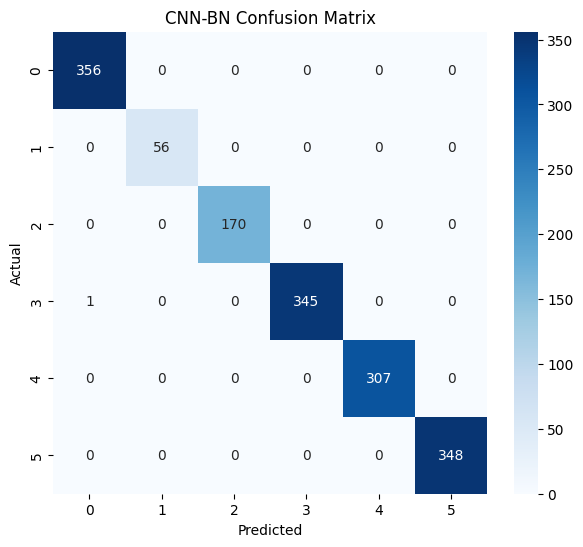

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion(model, loader, title):
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds.extend(out.argmax(1).cpu().numpy())
            trues.extend(y.numpy())

    cm = confusion_matrix(trues, preds)

    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion(model_cnn_bn, val_loader, "CNN-BN Confusion Matrix")


# t-SNE visualisation of Embeddings

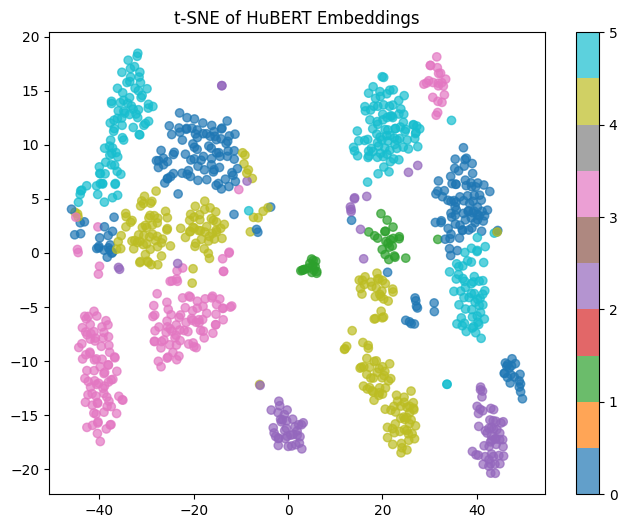

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def extract_features(dataset, n=1000):
    xs = []
    ys = []
    for i in range(min(n, len(dataset))):
        x, y = dataset[i]
        xs.append(x.mean(0).numpy())  # average pooling of sequence
        ys.append(y)
    return np.array(xs), np.array(ys)

# Extract features
X, Y = extract_features(dataset)

# t-SNE
tsne = TSNE(n_components=2, perplexity=40, learning_rate=200)
X2 = tsne.fit_transform(X)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(X2[:,0], X2[:,1], c=Y, cmap="tab10", alpha=0.7)
plt.title("t-SNE of HuBERT Embeddings")
plt.colorbar(scatter)
plt.show()


# ROC curve

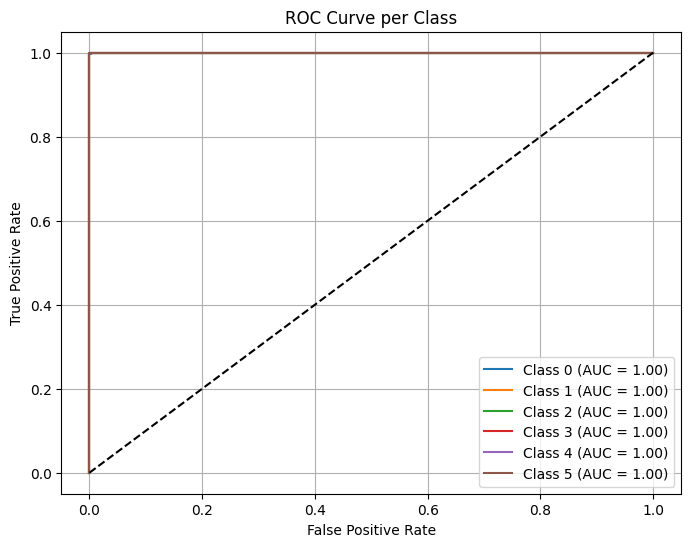

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_roc(model, loader, num_classes=6):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            probs = out.softmax(1).cpu().numpy()
            all_probs.append(probs)
            all_labels.extend(y.numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.array(all_labels)

    # Binarize labels
    y_bin = label_binarize(all_labels, classes=list(range(num_classes)))

    plt.figure(figsize=(8,6))

    for c in range(num_classes):
        fpr, tpr, _ = roc_curve(y_bin[:,c], all_probs[:,c])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {c} (AUC = {roc_auc:.2f})")

    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve per Class")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc(model_cnn_bn, val_loader)


# **Final model: only weights best for app**

In [ ]:
save_path = "/content/drive/MyDrive/models/cnn_bn_final.pt"
torch.save(model_cnn_bn.state_dict(), save_path)
print("Saved model to:", save_path)


Saved model to: /content/drive/MyDrive/models/cnn_bn_final.pt


# **Final Model: Full (with architecture+ weights)**

In [ ]:
save_path_full = "/content/drive/MyDrive/models/cnn_bn_full.pth"
torch.save(model_cnn_bn, save_path_full)
print("Saved full model to:", save_path_full)


Saved full model to: /content/drive/MyDrive/models/cnn_bn_full.pth


In [ ]:
torch.save(model_cnn_bn, "/content/drive/MyDrive/models/cnn_bn_fullmodel.pt")
